In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
df = pd.read_csv('/content/drive/MyDrive/IRIS.csv')

In [17]:
print(df.head())

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [20]:
print(df.shape)

(150, 5)


In [21]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [24]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [25]:
df.dtypes

,0
sepal_length,float64
sepal_width,float64
petal_length,float64
petal_width,float64
species,object


In [26]:
print(df.corr(numeric_only=True))

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000


In [28]:
df.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0
species,0


In [29]:
print(df['species'].value_counts())

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [30]:
df['species'] = df['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})

In [31]:
for column in df.columns[:-1]:  # exclude 'species'
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# Final Model

Accuracy: 0.9333333333333333
Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



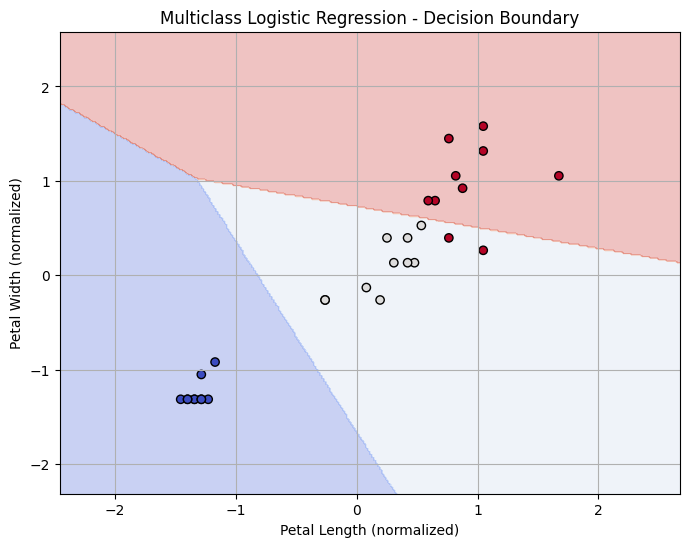

In [36]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Load Dataset ---
df = pd.read_csv('/content/drive/MyDrive/IRIS.csv')  # Update path if needed
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
df['species'] = df['species'].map(label_map)

# --- Feature Selection & Normalization ---
X = df[['petal_length', 'petal_width']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = df['species'].values

# --- One-Hot Encoding ---
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y_encoded = one_hot(y, 3)

# --- Train/Val/Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

# --- Add Bias Term ---
def add_bias(X): return np.hstack([np.ones((X.shape[0], 1)), X])
X_train_b, X_val_b, X_test_b = add_bias(X_train), add_bias(X_val), add_bias(X_test)

# --- Softmax & Helper Functions ---
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def predict(X, weights): return softmax(np.dot(X, weights))

def compute_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

def compute_gradients(X, y_true, y_pred):
    return np.dot(X.T, (y_pred - y_true)) / X.shape[0]

# --- Initialize Weights ---
np.random.seed(0)
weights = np.random.randn(X_train_b.shape[1], 3)

# --- Training ---
lr = 0.1
epochs = 1000
losses = []

for epoch in range(epochs):
    y_pred = predict(X_train_b, weights)
    loss = compute_loss(y_train, y_pred)
    grad = compute_gradients(X_train_b, y_train, y_pred)
    weights -= lr * grad
    losses.append(loss)

# --- Evaluation on Test Set ---
y_pred_test = np.argmax(predict(X_test_b, weights), axis=1)
y_true_test = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))
print("Classification Report:\n", classification_report(y_true_test, y_pred_test))

# --- Plot Decision Boundary ---
def plot_decision_boundary(X, y_onehot, weights):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_b = add_bias(grid)
    probs = predict(grid_b, weights)
    preds = np.argmax(probs, axis=1)
    preds = preds.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y_onehot, axis=1), edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Petal Length (normalized)")
    plt.ylabel("Petal Width (normalized)")
    plt.title("Multiclass Logistic Regression - Decision Boundary")
    plt.grid(True)
    plt.show()

plot_decision_boundary(X_test, y_test, weights)